# Lab 3: Generating Data

Based on assignments by Lisa Zhang and Jimmy Ba.

In this lab, you will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded. 

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

In the process, you are expected to learn to:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.


### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

https://drive.google.com/file/d/1pB0neiq98jJVQ-f3J_GjfBrlwB__MS7m/view?usp=sharing

# PART A - Autoencoder [20 pt]

In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Note that you will need to use the Colab GPU for this assignment.

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

In [1]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [2]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3


/content/a3


In [3]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [4]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz


## Part 1. Data Preparation [7 pt]

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks. 

### Part (a) [1pt]
Verify that the dataset has loaded correctly. How many samples do we have? How is the data organized?

In [5]:
# code to examine the dataset
# m is a tuple
# Tuple items are indexed, 
# the first item has index [0], the second item has index [1] etc.
m.index

<function tuple.index>

The tuple contains the training and the testing set. Both the training and testing are in pairs samples/labels so of length =2 overall each. A pair of sample-labels. We need the sample part which is [0] from each element.

In [6]:
m[0]

(array([[[[ 59,  43,  50, ..., 158, 152, 148],
          [ 16,   0,  18, ..., 123, 119, 122],
          [ 25,  16,  49, ..., 118, 120, 109],
          ...,
          [208, 201, 198, ..., 160,  56,  53],
          [180, 173, 186, ..., 184,  97,  83],
          [177, 168, 179, ..., 216, 151, 123]],
 
         [[ 62,  46,  48, ..., 132, 125, 124],
          [ 20,   0,   8, ...,  88,  83,  87],
          [ 24,   7,  27, ...,  84,  84,  73],
          ...,
          [170, 153, 161, ..., 133,  31,  34],
          [139, 123, 144, ..., 148,  62,  53],
          [144, 129, 142, ..., 184, 118,  92]],
 
         [[ 63,  45,  43, ..., 108, 102, 103],
          [ 20,   0,   0, ...,  55,  50,  57],
          [ 21,   0,   8, ...,  50,  50,  42],
          ...,
          [ 96,  34,  26, ...,  70,   7,  20],
          [ 96,  42,  30, ...,  94,  34,  34],
          [116,  94,  87, ..., 140,  84,  72]]],
 
 
        [[[154, 126, 105, ...,  91,  87,  79],
          [140, 145, 125, ...,  96,  77,  71],
   

In [7]:
print(" The training samples and labels pair: ",len(m[0]))

 The training samples and labels pair:  2


In [8]:
m[1]

(array([[[[158, 159, 165, ..., 137, 126, 116],
          [152, 151, 159, ..., 136, 125, 119],
          [151, 151, 158, ..., 139, 130, 120],
          ...,
          [ 68,  42,  31, ...,  38,  13,  40],
          [ 61,  49,  35, ...,  26,  29,  20],
          [ 54,  56,  45, ...,  24,  34,  21]],
 
         [[112, 111, 116, ...,  95,  91,  85],
          [112, 110, 114, ...,  95,  91,  88],
          [110, 109, 111, ...,  98,  95,  89],
          ...,
          [124, 100,  88, ...,  97,  64,  85],
          [116, 102,  85, ...,  82,  82,  64],
          [107, 105,  89, ...,  77,  84,  67]],
 
         [[ 49,  47,  51, ...,  36,  36,  33],
          [ 51,  40,  45, ...,  31,  32,  34],
          [ 47,  33,  36, ...,  34,  34,  33],
          ...,
          [177, 148, 137, ..., 146, 108, 127],
          [168, 148, 132, ..., 130, 126, 107],
          [160, 149, 132, ..., 124, 129, 110]]],
 
 
        [[[235, 231, 232, ..., 233, 233, 232],
          [238, 235, 235, ..., 236, 236, 235],
   

In [9]:
print(" The testing samples and labels pair: ",len(m[1]))

 The testing samples and labels pair:  2


In [10]:
print(" All the samples are:",len(m[0][0])+len(m[1][0]))

 All the samples are: 60000


First elements

In [11]:
print("The training samples:", len(m[0][0]))

The training samples: 50000


Second elements 

In [12]:
print("The testing samples: ", len(m[1][0]))

The testing samples:  10000


### Part (b) [2pt]
Preprocess the data to select only images of horses. Learning to generate only hourse images will make our task easier. Your function will also convert the colour images to greyscale to create our input data.

In [13]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


In [14]:
trainRGB,trainGREY=process(m[0][0], m[0][1], max_pixel=256.0, downsize_input=False)

Sample value normalized and shuffled colour images RBG training shape of horses.The value of trainRGB[1] is 1 since it is only once channel in greyscale 

In [15]:
trainRGB.shape

(5000, 3, 32, 32)

Sample value training greyscale images, also normalized so values are between 0 and 1. The value of trainGREY[1] is 1 since it is only once channel in greyscale 

In [16]:
trainGREY.shape

(5000, 1, 32, 32)

In [17]:
testRGB,testGREY = process(m[1][0], m[1][1], max_pixel=256.0, downsize_input=False)

In [18]:
testRGB.shape

(1000, 3, 32, 32)

In [19]:
testGREY.shape

(1000, 1, 32, 32)

### Part (c) [2pt]
Create a dataloader (or function) to batch the samples.

In [20]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)

In [21]:
xbatch,ybatch = next(iter(get_batch(trainGREY,trainRGB, 10)))

In [22]:
len(xbatch)

10

In [23]:
len(ybatch)

10

### Part (e) [2pt]
Verify and visualize that we are able to generate different batches of data.

In [24]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)


Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [25]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [26]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches
The batch size is 10 so shapes are expected thank you for the starter code :) 

In [27]:
# obtain batches of images
xs, ys = next(iter(get_batch(train_grey, train_rgb, 10)))
print(xs.shape, ys.shape)

(10, 1, 32, 32) (10, 3, 32, 32)


Visualization

The arguments of .subplot: <br>
Three integers (nrows, ncols, index). The subplot will take the index position on a grid with nrows rows and ncols columns. index starts at 1 in the upper left corner and increases to the right. index can also be a two-tuple specifying the (first, last) indices (1-based, and including last) of the subplot, e.g., fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure.

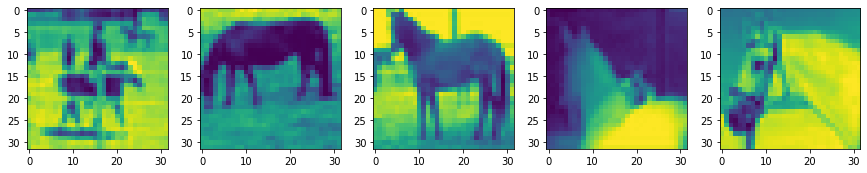

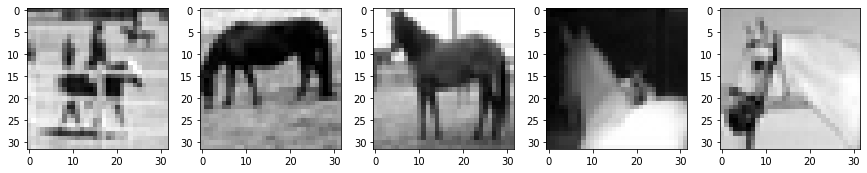

In [28]:
# visualize 5 train/test images
plt.figure(figsize=(15,15))

#enumerate is useful for obtaining an indexed list:
#(0, seq[0]), (1, seq[1]), (2, seq[2])

for i,elem in enumerate(train_rgb):
  if i>=5: 
    break
  else:
    plt.subplot(5,5,i+1)
    # we need the samples so elem[0] // elem[1] are the labels
    plt.imshow(elem[0])

plt.figure(figsize=(15,15))

for i,elem in enumerate(train_grey):
  if i>=5: 
    break
  else:
    plt.subplot(5,5,i+1)
    plt.imshow(elem[0],cmap='gray')


## Part 2. Colourization as Regression [5 pt]

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

In this section, you will get familar with training neural networks using cloud GPUs. Run the helper code and answer the questions that follow.

#### Helper Code

Regression Architecture

In [29]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [30]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
        
        print(epoch, loss.cpu().detach())
        if args.plot:
          visual(images, labels, outputs, args.gpu, 1)
    
    return gen

Training visualization code

In [31]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

In [32]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

### Part (a) [1 pt]
Describe the model RegressionCNN. How many convolution layers does it have? What are the filter sizes and number of filters at each layer? Construct a table or draw a diagram.

Answer: <br>
- There are 6 convolution layers. <br>
- The first two convolutional layers are the encoder part creating the embeddings and decreasing the input's dimensions.
-Then, the last two layers are part of the decoder part to allow us to have the same dimension as the first input of conv1. 
- The final convolutional is added to fix any error in dimensions. 

        args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

In [33]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable2 = PrettyTable([" Convolution Layer  ", "  Number of filters  ", "  Filter size  "])
  
# Add rows
myTable2.add_row(["Conv1", "32", "3"])
myTable2.add_row(["Conv2", "64", "3"])
myTable2.add_row(["Conv3", "64", "3"])
myTable2.add_row(["Conv4", "32", "3"])
myTable2.add_row(["Conv5", "3", "3"])
myTable2.add_row(["Conv6", "3", "3"])

In [34]:
myTable2

Convolution Layer,Number of filters,Filter size
Conv1,32,3
Conv2,64,3
Conv3,64,3
Conv4,32,3
Conv5,3,3
Conv6,3,3


### Part (b) [1 pt]
Run the regression training code (should run without errors). This will generate some images. How many epochs are we training the CNN model in the given setting? <br> <br>
We have 25 epochs 

In [35]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

Answer:

### Part (c) [3 pt]
Re-train a couple of new models using a different number of training epochs. You may train each new models in a new code cell by copying and modifying the code from the last notebook cell. Comment on how the results (output images, training loss) change as we increase or decrease the number of epochs.

Answer:

The expected results are as we decrease the number of epochs the less we learn since and our model will perform worse. The convenient way of tuning would be then to increase the number of epochs. But as we have seen the results are not that perfect even if our model loss function is still decreasing more and more as we increase the number of epochs so the problem of the model's performance comes from the model's itself. As discussed in the lecture if we use an MSE as our loss function we will an averaging effect and thus our reconstructed image will be blurry.

## **Lowering the epochs** 

Epochs=5

The loss was 0.0086 when the training epoch=25. When traning epochs=5  the loss achieved was 0.0136. As expected the loss increased. <br>
On the other hand, consequently the reconstructed images are bit as good as training results with epoch=25. Notice the pink borders and the blurry fake images. 

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 tensor(0.1027)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


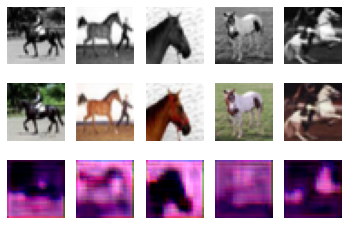

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 tensor(0.0402)


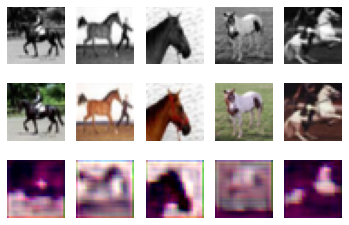

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 tensor(0.0232)


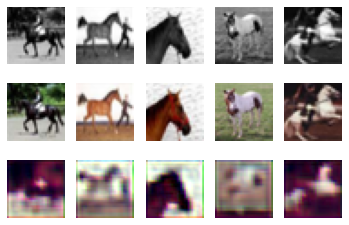

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 tensor(0.0176)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


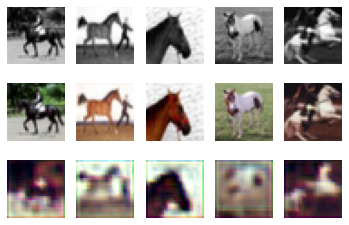

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 tensor(0.0153)


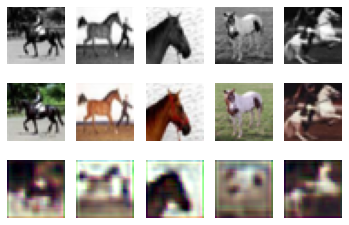

In [36]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 5,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Epochs=10

The loss was 0.0086 when the training epoch=25. When traning epochs=10 the loss achieved was 0.0112. As expected the loss increased. As for the fake images reconstruction same answer as with epoch=5.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 tensor(0.0394)


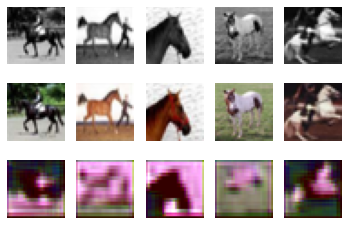

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 tensor(0.0220)


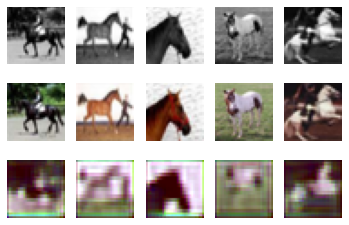

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 tensor(0.0183)


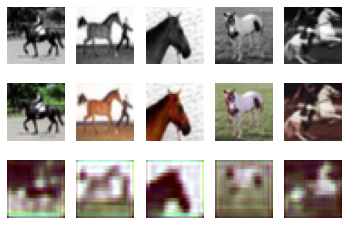

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 tensor(0.0164)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


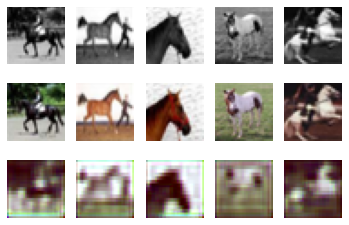

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 tensor(0.0151)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


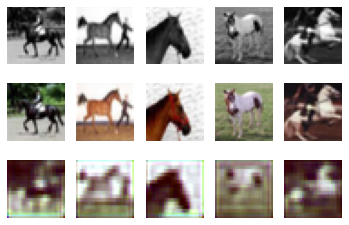

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 tensor(0.0141)


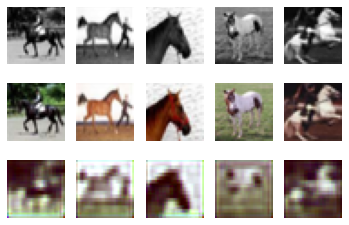

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 tensor(0.0133)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


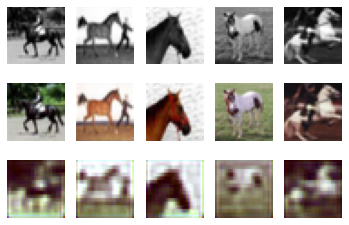

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 tensor(0.0127)


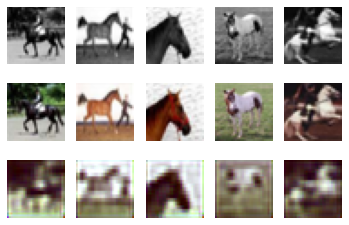

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 tensor(0.0123)


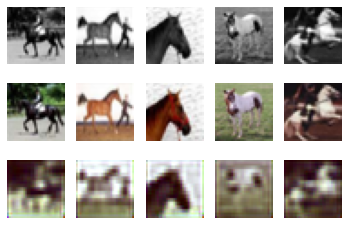

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9 tensor(0.0118)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


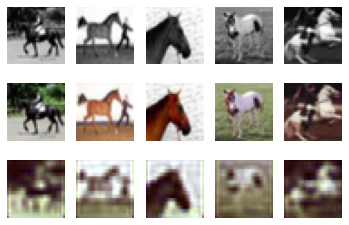

In [37]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 10,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Epochs=15

The loss was 0.0086 when the training epoch=25. When traning epochs=15 the loss achieved was 0.0112. As expected the loss increased. As for the fake images reconstruction same answer as with epoch=5 .

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 tensor(0.0571)


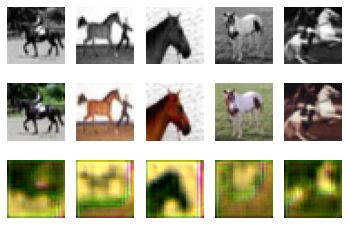

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 tensor(0.0225)


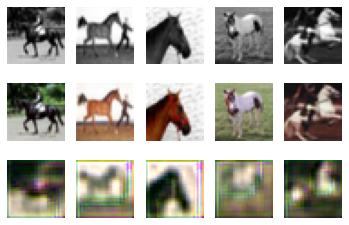

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 tensor(0.0191)


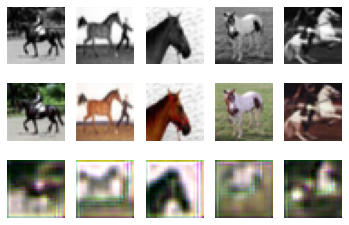

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 tensor(0.0174)


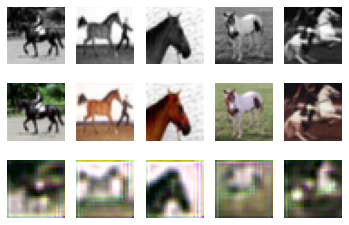

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 tensor(0.0160)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


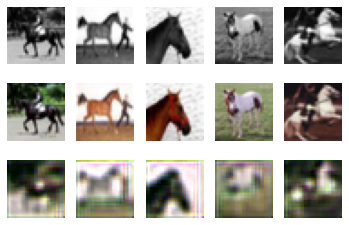

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 tensor(0.0149)


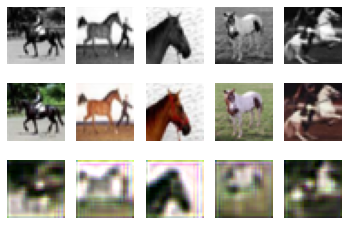

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 tensor(0.0139)


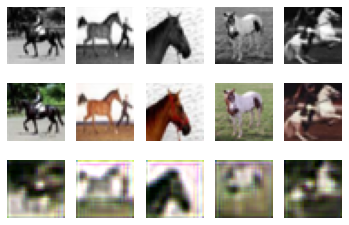

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 tensor(0.0131)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


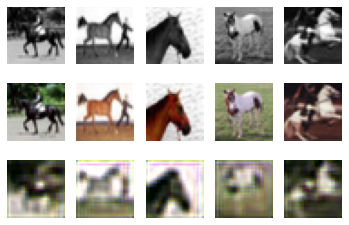

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 tensor(0.0125)


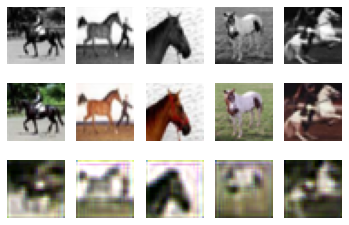

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9 tensor(0.0119)


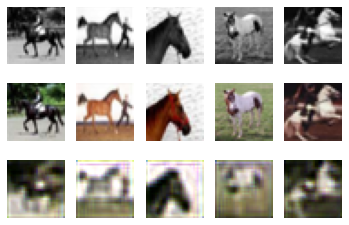

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10 tensor(0.0114)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


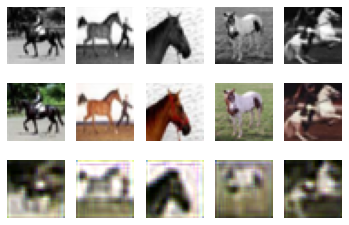

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11 tensor(0.0111)


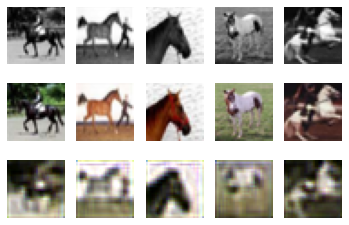

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12 tensor(0.0108)


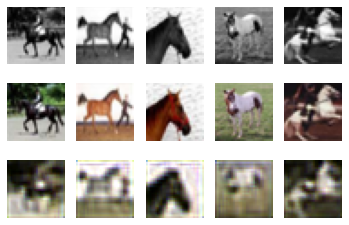

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13 tensor(0.0105)


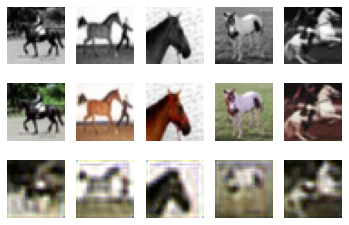

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 tensor(0.0103)


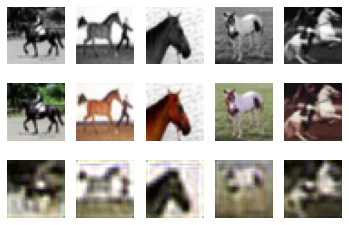

In [38]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 15,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

# **Increasing the number of epochs** 

Epochs=35

The loss when the epochs were 25 was 0.0086, but when we increased to 35 the number of epochs, it decreased to 0.0085. 
Increasing the number of epochs decreases our loss. We should examine if we increase more and more the epoch number if it will be still the case. 
As for the image reconstruction, the  fake images are a bit less blurry but not that much noticeable improvement (very slight).

In [39]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 35,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

Epochs=45

The loss when the epochs were 25 was 0.0086, but when we increased to 35 the number of epochs, it decreased to 0.0078 .

As for the image reconstruction, the  fake images are a less blurry .

In [40]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 45,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

Epochs=75

The loss also decreased to 0.0065 but we kind of reached a maximum in terms of the the quality achieved for the reconstructed images since they are still kind of blurry (less than before) so the  loss function might be the problem (how we are solving the problem). As explained in the lecture it is  kind of averaging the thus that explains the results.

In [41]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 75,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

Epoch=150

The loss also decreased more and reached 0.0053 but we kind of reached a maximum in terms of the the quality achieved for the reconstructed images since they are still kind of blurry (less than before) so the  loss function might be the problem (how we are solving the problem). As explained in the lecture MSE  is  kind of averaging the thus that explains the results.

In [42]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 150,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

## Part 3. Skip Connections [8 pt]
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. We will introduce skip connections.

### Part (a) [4 pt]
Add a skip connection from the first layer to the last, second layer to the second last, etc.
That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [3], and is called a "UNet". Following the CNN class that you have completed, complete the __init__ and forward methods of the UNet class.
Hint: You will need to use the function torch.cat.

keras.layers.Conv2D(filters, kernel_size, strides=(1, 1),
  padding='valid', data_format=None, dilation_rate=(1, 1),
  activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  bias_initializer='zeros', kernel_regularizer=None,
  bias_regularizer=None, activity_regularizer=None,
  kernel_constraint=None, bias_constraint=None)

https://amaarora.github.io/2020/09/13/unet.html <br>

Changes in architecture (class)? Since the in_channels and out_channels values are different in the decoding stage we need to change the input channnels since we will input 2 inputs to decoder <br> 
Changes in the forward method? we need to perform feature concatenation since we have 2 inputs.


In [43]:
#complete the code
# Add a skip connection from ths first layer to the last, second layer to the second last, etc. 

# What should I change in the architecture? 
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
          
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            # the input channels will be from the 2nd layer so we 
            # should add a *2 to the number of input channels 
            nn.Conv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            # since we will be feeding the input 
            # with 2 inputs from the  b and W imagaes and the output of layer 1 upgrade (num_filters + num_filters)
            nn.Conv2d(2*num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        # the final convolution will have inputs from conv2 and from the initial input channel 
        #input having 1 channels (since it is a grey image)
        self.finalconv = nn.Conv2d(3+1, 3, kernel_size=kernel, padding=padding)



    def forward(self, x):
      
        out1 = self.downconv1(x)
        out2 = self.downconv2(out1)
        out3 = self.rfconv(out2)
        out4 = self.upconv1(torch.cat([out3, out2], dim=1))
        out5 = self.upconv2(torch.cat([out4, out1], dim=1))
        # final output
        out = self.finalconv(torch.cat([out5, x], dim=1))
        return out
      

### Part (b) [2 pt]
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100. How does the result compare to the previous model? Did skip connections improve the validation loss and accuracy? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

Answer: <br>
No need for accuracy since it is not a classification problem we will compare them using the MSE loss on training and val since it is a regression problem where we are using MSE loss to see the pixel difference between  true labels and the generated fake images.<br> 
As we can see the skip connections reduced the loss from 0.0086 to 0.0050 using 25 epochs. As for our fake images they are now of better quality than the previous model (and less blurry). The previous model results are on the left and the skip-connection results are on the right in the image below. <br> 
Skip connections improves the CNN performance because:
- Keeps information from previous layers so that it makes sure that the information is not lost in the forward pass stage and thus achieving a smaller loss.
-  Helps in solving the vanishing gradient problem.


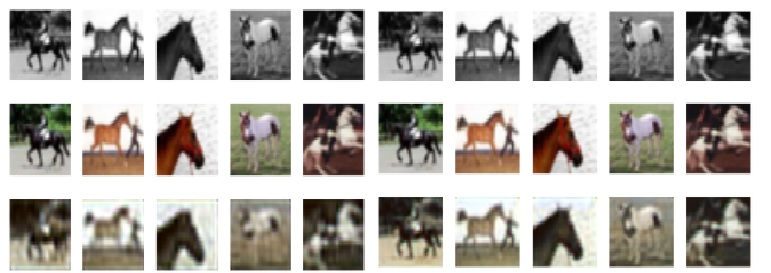

In [44]:
from sklearn.metrics import accuracy_score
def train_withloss(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
   
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # get the validation images and validation labels
        # get_torch_vars --> Helper function to convert numpy arrays to pytorch tensors. 
        # If GPU is used, move the tensors to GPU.
        image_val, labels_val = get_torch_vars(test_grey,test_rgb,args.gpu)
        # the validation output using our model
        out_val=gen(image_val)
        # validation loss
        lossval=criterion(out_val,labels_val) 
        #take the avg
        train_losses.append(np.average(loss.data.item()))
        valid_losses.append(np.average(lossval.data.item()))
        
        #acct=accuracy_score(labels, outputs)
        #acctv=accuracy_score(labels_val, out_val)
        #train_accs.append(np.average(acct.data.item()))
        #valid_accs.append(np.average(acctv.data.item()))

        print(epoch, loss.cpu().detach())
        if args.plot:
          visual(images, labels, outputs, args.gpu, 1)
    
    return gen,train_losses,valid_losses

In [45]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn,train_losses,valid_losses = train_withloss(args)

Output hidden; open in https://colab.research.google.com to view.

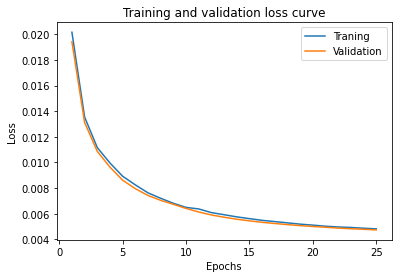

In [46]:
plt.title("Training and validation loss curve")
plt.plot(np.arange(1,26),train_losses,label="Traning")
plt.plot(np.arange(1,26),valid_losses,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Part (c) [2 pt]
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs. Describe the effect of batch sizes on the training/validation loss, and the final image output.

# **Lowering the batch_size**

In [47]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable3 = PrettyTable([" Batch_size ", "Loss_last_epoch"])
  
# Add rows
myTable3.add_row(["20", "0.0027"])
myTable3.add_row(["50", "0.0041"])
myTable3.add_row(["100", "0.0050"])

Reducing the batch size reduced the traning loss at epoch 25 (see the table). In both cases were batch_size=20 and batch_size=50 we got better results in terms of fake images quality since thet look closer to the real colored images. <br> 
Looking at batch_size=50 and batch_size=20, batch_size=20 gave a lower validation loss so I  would pick batch_size=20. Lowering more the batch size would create more noisy training. We can notice that the training with batch size=50 is smoother than with batch_size=20.

In [48]:
myTable3

Batch_size,Loss_last_epoch
20,0.0027
50,0.0041
100,0.0050


Batch_size=20

In [49]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 20,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn,train_losses,valid_losses = train_withloss(args)

Output hidden; open in https://colab.research.google.com to view.

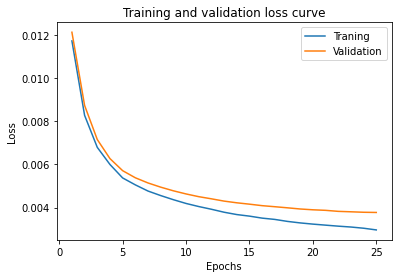

In [50]:
plt.title("Training and validation loss curve")
plt.plot(np.arange(1,26),train_losses,label="Traning")
plt.plot(np.arange(1,26),valid_losses,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
print("Training loss",train_losses[-1])
print(end='\n')
print("Validation loss",valid_losses[-1])

Training loss 0.0029635156970471144

Validation loss 0.0037716033402830362


Batch_size=50 

In [52]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn,train_losses,valid_losses = train_withloss(args)

Output hidden; open in https://colab.research.google.com to view.

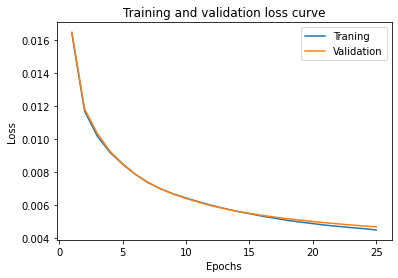

In [53]:
plt.title("Training and validation loss curve")
plt.plot(np.arange(1,26),train_losses,label="Traning")
plt.plot(np.arange(1,26),valid_losses,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [54]:
print("Training loss",train_losses[-1])
print(end='\n')
print("Validation loss",valid_losses[-1])

Training loss 0.004516866523772478

Validation loss 0.00470459321513772


# **Increasing the batch_size**

Increasing the batch size from 100 to 200 and 400 increased our trainng and validation loss at the last epoch. Also notice that the quality of obtaning fake images decreased alot. The quality of fake images and the train & validation loss obtained for lower bacth size is way better.

In [55]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable4 = PrettyTable([" Batch_size ", "Loss_last_epoch"])
  
# Add rows

myTable4.add_row(["100", "0.0050"])
myTable4.add_row(["200", "0.0054"])
myTable4.add_row(["400", "0.0083"])
myTable4

Batch_size,Loss_last_epoch
100,0.0050
200,0.0054
400,0.0083


Batch_size=200 

In [56]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 200,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn,train_losses,valid_losses = train_withloss(args)

Output hidden; open in https://colab.research.google.com to view.

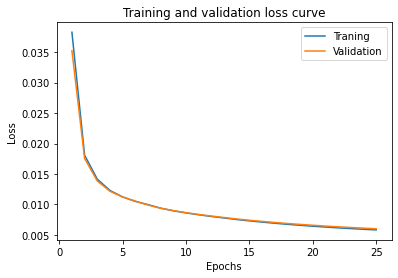

In [57]:
plt.title("Training and validation loss curve")
plt.plot(np.arange(1,26),train_losses,label="Traning")
plt.plot(np.arange(1,26),valid_losses,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [58]:
print("Training loss",train_losses[-1])
print(end='\n')
print("Validation loss",valid_losses[-1])

Training loss 0.005805495195090771

Validation loss 0.005993643309921026


Batch_size=400

In [59]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 400,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn,train_losses,valid_losses = train_withloss(args)

Output hidden; open in https://colab.research.google.com to view.

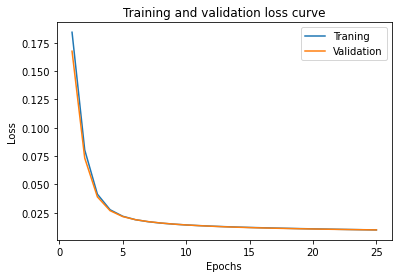

In [60]:
plt.title("Training and validation loss curve")
plt.plot(np.arange(1,26),train_losses,label="Traning")
plt.plot(np.arange(1,26),valid_losses,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
print("Training loss",train_losses[-1])
print(end='\n')
print("Validation loss",valid_losses[-1])

Training loss 0.009799148887395859

Validation loss 0.009805393405258656


# PART B - Conditional GAN [30 pt]

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task.

## Part 1. Conditional GAN [15 pt]

To start we will be modifying the previous sample code to construct and train a conditional GAN. We will exploring the different architectures to identify and select our best image colourization model.

Note: This second half of the assignment should be started after the lecture on generative adversarial networks (GANs). 


### Part (a) [3 pt]
Modify the provided training code to implement a generator. Then test to verify it works on the desired input (Hint: you can reuse some of your earlier autoencoder models here to act as a generator)

I used the same skip-net architecture used earlier now it is just implemented as a Generator in our GAN architecture. But the only thing I modified is that I have put LeakyReLU(0.2, inplace=True) in the place of ReLU.

In [62]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            # the input channels will be from the 2nd layer so we 
            # should add a *2 to the number of input channels 
            nn.Conv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            # since we will be feeding the input 
            # with 2 inputs from the  b and W imagaes and the output of layer 1 upgrade (num_filters + num_filters)
            nn.Conv2d(2*num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        # the final convolution will have inputs from conv2 and from the initial input channel 
        #input having 1 channels (since it is a grey image)
        self.finalconv = nn.Conv2d(3+1, 3, kernel_size=kernel, padding=padding)

 



    def forward(self, x):
      out1 = self.downconv1(x)
      out2 = self.downconv2(out1)
      out3 = self.rfconv(out2)
      out4 = self.upconv1(torch.cat([out3, out2], dim=1))
      out5 = self.upconv2(torch.cat([out4, out1], dim=1))
      # final output
      out = self.finalconv(torch.cat([out5, x], dim=1))
      return out


In [63]:
#test generator architecture

# 'kernel' and 'num_filters' as arguments 
model_generator= Generator(3,32)

input_image= torch.rand(100,1,32,32)
print("The input shape of 1st test image is in grayscale (having 1 channels): ",input_image.shape)

fake_image=model_generator(input_image)

print("The output fake image should be 3 channels: ",fake_image.shape)

The input shape of 1st test image is in grayscale (having 1 channels):  torch.Size([100, 1, 32, 32])
The output fake image should be 3 channels:  torch.Size([100, 3, 32, 32])


In [64]:
print("The test input image \n")
print(input_image)

The test input image 

tensor([[[[0.7110, 0.0694, 0.5237,  ..., 0.1831, 0.0711, 0.6805],
          [0.6539, 0.3856, 0.1290,  ..., 0.5972, 0.6469, 0.1378],
          [0.5852, 0.5188, 0.3919,  ..., 0.6463, 0.3982, 0.1942],
          ...,
          [0.5642, 0.8416, 0.1805,  ..., 0.2853, 0.3847, 0.2809],
          [0.9746, 0.4470, 0.9567,  ..., 0.0832, 0.7132, 0.0573],
          [0.9627, 0.2778, 0.5307,  ..., 0.9719, 0.5895, 0.4291]]],


        [[[0.6509, 0.9880, 0.2337,  ..., 0.5277, 0.9411, 0.1785],
          [0.5258, 0.5431, 0.4225,  ..., 0.6925, 0.5480, 0.9421],
          [0.8828, 0.4082, 0.6154,  ..., 0.5279, 0.7233, 0.8389],
          ...,
          [0.4961, 0.7328, 0.6459,  ..., 0.7702, 0.3052, 0.8937],
          [0.8359, 0.6125, 0.1908,  ..., 0.8342, 0.4240, 0.8556],
          [0.1112, 0.9964, 0.2064,  ..., 0.3036, 0.4897, 0.8654]]],


        [[[0.4075, 0.5720, 0.2042,  ..., 0.0277, 0.2927, 0.1020],
          [0.1189, 0.6133, 0.5218,  ..., 0.2918, 0.4228, 0.0096],
          [0.86

In [65]:
print("The fake image \n")
print(fake_image)
print("The generator model works")

The fake image 

tensor([[[[-2.9489e-01, -2.7442e-01, -2.1694e-01,  ...,  1.9390e-01,
           -2.6839e-01, -2.9032e-01],
          [-2.0120e-01, -2.5064e-01, -1.9872e-01,  ...,  5.4172e-02,
           -4.5999e-02, -1.6627e-01],
          [ 5.7817e-02, -6.6071e-02, -4.6484e-01,  ..., -1.0951e-02,
           -8.7602e-02, -2.0120e-01],
          ...,
          [ 7.9686e-02,  1.8181e-01,  1.1385e-01,  ..., -3.0609e-01,
           -7.7616e-01, -5.8975e-01],
          [ 1.4898e-02, -1.9169e-02, -8.2696e-03,  ..., -6.2556e-01,
           -7.1744e-01, -3.3059e-01],
          [ 5.5700e-02,  2.7578e-02, -6.0091e-03,  ..., -4.6876e-01,
           -4.4171e-01, -2.4291e-01]],

         [[ 2.6087e-01, -2.6626e-02, -9.8731e-03,  ...,  4.7338e-01,
            3.6128e-01,  6.3419e-02],
          [ 2.6154e-01, -6.1284e-02, -7.0125e-03,  ...,  5.1296e-01,
            1.8109e-01, -2.0154e-01],
          [ 1.8108e-01, -7.0512e-03,  2.3191e-01,  ...,  2.8219e-01,
            4.1684e-02, -1.2153e-01],
   

Testing our generator on the dataset :) 

In [66]:
import torch.nn as nn

model=Generator(3,32)
model.cuda()
(x_train, y_train), (x_test, y_test) = load_cifar10()
train_rgb, train_grey = process(x_train, y_train, downsize_input=False)
(xs, ys) = next(iter(get_batch(train_grey, train_rgb, batch_size=30)))
images, labels = get_torch_vars(xs, ys,  gpu=True)
outputs = model(images)
print(outputs.shape)

File path: data/cifar-10-batches-py.tar.gz
torch.Size([30, 3, 32, 32])


Also output is correct size 

### Part (b) [3 pt]
Modify the provided training code to implement a discriminator. Then test to verify it works on the desired input.

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [67]:
class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.conv1=nn.Conv2d(3, 3, 2, padding=1)
        # self.conv2=nn.Conv2d(3, 3, 2, padding=1)

        # use LeakyRelu Instead of relu 
        self.norm=nn.BatchNorm2d(3)
        self.act=nn.LeakyReLU(0.2, inplace=True)
        self.pool=nn.MaxPool2d(2)
        self.fc1=nn.Linear(1792, 1024)
        #self.act2=nn.LeakyReLU(0.2, inplace=True)
        self.dropout=nn.Dropout(0.3)
        self.fc2=nn.Linear(1024, 64)
        self.fc3=nn.Linear(64, 32)
        self.fc4=nn.Linear(32, 1)
        # activation1 
        self.act1=nn.Sigmoid()

    def forward(self, x, img_greyscale):
        x= self.conv1(x)
        x=self.norm(x)
        x=self.act(x)
        x=self.pool(x)

        x = x.view(x.size(0), -1)

        c = img_greyscale.view(img_greyscale.size(0),-1)
        x = torch.cat([x, c], 1)
        x=self.fc1(x)
        x=self.act(x)
        x=self.dropout(x)
        x=self.fc2(x)
        x=self.act(x)
        x=self.dropout(x)
        x=self.fc3(x)
        x=self.act(x)
        x=self.dropout(x)
        x=self.fc4(x)
        x=self.act1(x)

        return x.squeeze()

In [68]:
# test discriminator architecture
#test generator architecture

# 'kernel' and 'num_filters' as arguments 
model_discriminator= Discriminator(3,32)

input_image_gray= torch.rand(100,1,32,32)
print("The input shape of 1st test image is in grayscale (having 1 channels): ",input_image_gray.shape)

# 2 inputs x from the generato and the input greyscale image
out=model_discriminator(fake_image,input_image_gray)

print("The output shape of the discriminator: ",out.shape)



The input shape of 1st test image is in grayscale (having 1 channels):  torch.Size([100, 1, 32, 32])
The output shape of the discriminator:  torch.Size([100])


Testing our discriminator on the dataset

In [69]:
import torch.nn as nn

model=Discriminator(3,32)
model.cuda()
(x_train, y_train), (x_test, y_test) = load_cifar10()
train_rgb, train_grey = process(x_train, y_train, downsize_input=False)
(xs, ys) = next(iter(get_batch(train_grey, train_rgb, batch_size=30)))
images, labels = get_torch_vars(xs, ys,  gpu=True)
outputs = model(labels, images)
print(outputs.shape)



File path: data/cifar-10-batches-py.tar.gz
torch.Size([30])


Our model works well then!

### Part (c) [3 pt]
Modify the provided training code to implement a conditional GAN.

In [70]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        # take the kernel size and the number of filter
        cnn = Generator(args.kernel,args.num_filters)
        # disriminator 
        discriminator = Discriminator(args.kernel,args.num_filters)


    # LOSS FUNCTION from prelab2B

    criterion = nn.BCELoss()                                                  
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()
            # train with real images
            real_validity = discriminator(img_real, img_grey)
            real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
            # train with fake images
            #z = Variable(torch.randn(batch_size, 100)).cuda()
            #fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
            fake_images = cnn(img_grey)
            fake_validity = discriminator(fake_images, img_grey)
            fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()
            #z = Variable(torch.randn(batch_size, 100)).cuda()
            #fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
            fake_images = cnn(img_grey)
            validity = discriminator(fake_images, img_grey)
            g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
            g_loss.backward()
            g_optimizer.step()


        # print and visualize
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        visual(images, img_real, fake_images, args.gpu, 1)

    return cnn

### Part (d) [3 pt]
Train a conditional GAN for image colourization.

In [71]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)


Output hidden; open in https://colab.research.google.com to view.

Try changing the nb of filters to 16 --> results are slightly better now 

In [72]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

to 10

In [73]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 10,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

to 5 

In [74]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 5,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

to 2 (better)

In [75]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 2,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

tp 52

In [76]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 52,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

to 100

In [77]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 100,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

**Introducing Discriminator2 (another discrimitor with more conv layers)**

The results are OK. We got slightky better results by using hyperparameter tuning on number_filters and this  gave us the best results . I will try to define another discriminator that good let's try using another discrminator other than the one created earlier. We will add more than one convolutional layer to the discrimininator.  I took the 3 first convolutional from the UNEt embedding part to capture more information from the generated fake imagess layers a and then fed them to the 4 FC layers. I believe with more conv layer we can capture more information from the generated fake image.

In [ ]:

class Discriminator2(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        
        self.downconv1 = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())
        self.fc1=nn.Linear(3*32*32, 1024)
        self.act2=nn.LeakyReLU(0.2, inplace=True)
        self.dropout=nn.Dropout(0.3)
        self.fc2=nn.Linear(1024, 64)
        self.fc3=nn.Linear(64, 32)
        self.fc4=nn.Linear(32, 1)
        self.act3=nn.Sigmoid()
    
    def forward(self, x, img_greyscale):         ### def forward(self, x, img_greyscale):
        
        ############### YOUR CODE GOES HERE ###############
        # ###################################################
        C1 = self.downconv1(x)
        C2 = self.downconv2(C1)
        x = self.rfconv(C2)
        
        x = x.view(x.size(0), -1)
        # print(x.shape)
        c = img_greyscale.view(img_greyscale.size(0),-1)
        x = torch.cat([x, c], 1)
        x=self.fc1(x)
        x=self.act2(x)
        x=self.dropout(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.dropout(x)
        x=self.fc3(x)
        x=self.act2(x)
        x=self.dropout(x)
        x=self.fc4(x)
        out=self.act3(x)



        return out.squeeze() # Flatten to [batch_size]

In [79]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train2(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        # take the kernel size and the number of filter
        cnn = Generator(args.kernel,args.num_filters)
        # disriminator 
        discriminator = Discriminator2(args.kernel,args.num_filters)


    # LOSS FUNCTION from prelab2B

    criterion = nn.BCELoss()                                                  
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size
            
            #discriminator training
            d_optimizer.zero_grad()
            # train with real images
            real_validity = discriminator(img_real, img_grey)
            real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
            # train with fake images
            #z = Variable(torch.randn(batch_size, 100)).cuda()
            #fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
            fake_images = cnn(img_grey)
            fake_validity = discriminator(fake_images, img_grey)
            fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()
            #z = Variable(torch.randn(batch_size, 100)).cuda()
            #fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
            fake_images = cnn(img_grey)
            validity = discriminator(fake_images, img_grey)
            g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
            g_loss.backward()
            g_optimizer.step()


        # print and visualize
        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        visual(images, img_real, fake_images, args.gpu, 1)

    return cnn

In [80]:
# test discriminator architecture
#test generator architecture

# 'kernel' and 'num_filters' as arguments 
model_discriminator= Discriminator2(3,16)

input_image_gray= torch.rand(100,1,32,32)
print("The input shape of 1st test image is in grayscale (having 1 channels): ",input_image_gray.shape)

# 2 inputs x from the generato and the input greyscale image
out=model_discriminator(fake_image,input_image_gray)

print("The output shape of the discriminator: ",out.shape)


The input shape of 1st test image is in grayscale (having 1 channels):  torch.Size([100, 1, 32, 32])
The output shape of the discriminator:  torch.Size([100])


In [81]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001, 
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train2(args)

Output hidden; open in https://colab.research.google.com to view.

### Part (e) [1 pt]
How does the performance of the cGAN compare with the autoencoder models that you tested in the first half of this assignment?

Answer:

The cGAN performance gives better results than the autoencoder model using MSE loss before. As explained in prelab and the lecture the MSE loss creates an averaging effect and that explain our prediction earlier. Now using cGAN the discriminator (the second one gave better results) helped the generator to give better results. The only downside of cGAn is that it took time to find the right discriminator to use and the right hyperparameter. 
The image are not yet perfectly reconstructed but are closer to the real one when compared to the other approach where we only used UNet.

### Part (f) [2 pt]

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

Answer:

https://biodifferences.com/difference-between-rods-and-cones.html#:~:text=Rods%20and%20Cones%20are%20the%20photoreceptors%20found%20in,are%20there%20in%20the%20centre%20of%20the%20retina.

The human perception of colour? <br>
- Biologically, cone and rodes are the photoreceptors responsible of our vision. Rods are responsible for seing at low light level (scotopic luminance levels) at night and are not sensitive to color (they are also more abundant than cones). Cones are activated at high light levels and give us the power to perceive colors. The cones sense Red , Green and Blue and thus we are able to see colors. <br> 
- An important point to note is that our eyes are not sensitive to all colors the same way. We perceive more green light than blue or red <br>.
- Modelling RBG colour perception using Squared distances could be then be problematic since we are taking into consideration only which colour/kind of light was emitted. i.e changing the perception of  color red with some variation x is equivalent to changing the perception of color green by some variation x --> this would give us the same squared distance but would perceived by us differently since we are more sensible to green than red and blue. Futhermore, implemening RGB colour space would be problematic since we are only accounting on the color and not taking the brigthness into account. 

## Part 2. Exploration [10 pt]

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there many other approaches we could take. In this part of the assignment you will be exploring at least one of several approaches towards improving our performance on the image colourization task. Some well known approaches you can consider include:

- lab colour space representation instead of RBG which simplifies the problem and requires you to predict two output channels instead of three
- k-means to represent RBG colourspace by 'k' distinct colours, this effectively changes the problem from regression to classification.

Other interesting approaches include:
- combining L1 loss along with the discriminator-based loss
- starting with a pretrained generator (i.e. Resnet)
- patch discriminator trained on local regions

A great example of some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>.

Note you are only required to pick one of the suggested modifications.

Answer: 

- Because of time constraint I will use this method --> lab colour space representation instead of RBG. We only should transform our images to lab colour space rep. It is the simplest. Also I should change in train function and the generator architecture since the input channels will be 2 instead of 3.


- Since we are dealing wih lab color change num_colour to 2 meaning that now we dont have RGB input <br>
- As we have seen this method improved alot the wuality of the colourized images!

In [91]:
# provide your code here

# change the num_colours to 2
class Generator2(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=2, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            # the input channels will be from the 2nd layer so we 
            # should add a *2 to the number of input channels 
            nn.Conv2d(num_filters*2*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            # since we will be feeding the input 
            # with 2 inputs from the  b and W imagaes and the output of layer 1 upgrade (num_filters + num_filters)
            nn.Conv2d(2*num_filters, 2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        # the final convolution will have inputs from conv2 and from the initial input channel 
        #input having 1 channels (since it is a grey image)
        self.finalconv = nn.Conv2d(2+1, 2, kernel_size=kernel, padding=padding)

 



    def forward(self, x):
      out1 = self.downconv1(x)
      out2 = self.downconv2(out1)
      out3 = self.rfconv(out2)
      out4 = self.upconv1(torch.cat([out3, out2], dim=1))
      out5 = self.upconv2(torch.cat([out4, out1], dim=1))
      # final output
      out = self.finalconv(torch.cat([out5, x], dim=1))
      return out



In [92]:
import torch.nn as nn

#model=Generator2(3,32)
#test generator architecture

# 'kernel' and 'num_filters' as arguments 
model_generator= Generator2(3,32)

input_image= torch.rand(100,1,32,32)
print("The input shape of 1st test image is in grayscale (having 1 channels): ",input_image.shape)

fake_image=model_generator(input_image)

print("The output fake image should be 2 channels: ",fake_image.shape)
print("Then you should transform lab images this output to RGB")

The input shape of 1st test image is in grayscale (having 1 channels):  torch.Size([100, 1, 32, 32])
The output fake image should be 2 channels:  torch.Size([100, 2, 32, 32])
Then you should transform lab images this output to RGB


In [93]:
# same as before but without convolutions

class Discriminator3(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        

        self.fc1=nn.Linear(3*32*32, 1024)
        self.act2=nn.LeakyReLU(0.2, inplace=True)
        self.dropout=nn.Dropout(0.3)
        self.fc2=nn.Linear(1024, 64)
        self.fc3=nn.Linear(64, 32)
        self.fc4=nn.Linear(32, 1)
        self.act3=nn.Sigmoid()
    
    def forward(self, x, img_greyscale):         ### def forward(self, x, img_greyscale):
        
        ############### YOUR CODE GOES HERE ###############
        # ###################################################
        #C1 = self.downconv1(x)
        #C2 = self.downconv2(C1)
        #x = self.rfconv(C2)
        
        #x = x.view(x.size(0), -1)
        # x numpy array
        x = x.reshape(x.size(0), -1)
        # print(x.shape)
        c = img_greyscale.view(img_greyscale.size(0),-1)
        x = torch.cat([x, c], 1)
        x=self.fc1(x)
        x=self.act2(x)
        x=self.dropout(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.dropout(x)
        x=self.fc3(x)
        x=self.act2(x)
        x=self.dropout(x)
        x=self.fc4(x)
        out=self.act3(x)



        return out.squeeze() # Flatten to [batch_size]

In [94]:
# test discriminator architecture
#test generator architecture

# 'kernel' and 'num_filters' as arguments 
model_discriminator= Discriminator3(3,16)

input_image_gray= torch.rand(100,1,32,32)
print("The input shape of 1st test image is in grayscale (having 1 channels): ",input_image_gray.shape)

# 2 inputs x from the generato and the input greyscale image
out=model_discriminator(fake_image,input_image_gray)

print("The output shape of the discriminator: ",out.shape)


The input shape of 1st test image is in grayscale (having 1 channels):  torch.Size([100, 1, 32, 32])
The output shape of the discriminator:  torch.Size([100])


https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8

In [95]:
from skimage.color import rgb2lab, lab2rgb

def labtorgb(L1,ab1): #Function to convert from lab 2 rgb
  L1=L1.detach().cpu().numpy()
  ab1=ab1.detach().cpu().numpy()
  ab1= ab1 * 110  #Unnormalizing
  L1=(L1+1.)*50 #Unnormalizing

  trial=np.concatenate((L1,ab1),axis=1)

  trial=np.transpose(trial, (0,2,3,1)) #Makes the dimensions appropriate for lab2rgb
  trial_lab=[]

  for i in trial:
    img=lab2rgb(i)
    trial_lab.append(img*255.) #scales back to RGB

  trial_lab=np.array(trial_lab)
  trial_lab=trial_lab.astype(np.uint8)

  return np.stack(trial_lab,axis=0), L1

In [100]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() 
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

# we should make the images form RGB to lab and then after output from the discriminator lab to RGB
def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn =Generator2(args.kernel,args.num_filters)
        discriminator = Discriminator3(args.kernel,args.num_filters)


    # LOSS FUNCTION

    criterion = nn.BCELoss()                                                     
    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

    # Transpose to match dimensions
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10(transpose=True)
    
    train_rgb, train_grey = process(x_train, y_train, downsize_input=False)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=False)

    # transforming to lab from rgb to input to generator 
    train_lab=rgb2lab(train_rgb).astype("float32")

    #normalizing train lab 
    train_lab[:,:,:,:1]=train_lab[:,:,:,:1] / 50. - 1. 
    train_lab[:,:,:,1:]= train_lab[:,:,:,1:] / 110. 
    # making it back regular dimensions  
    train_lab=np.transpose(train_lab,(0,3,1,2)) 
    trainL=train_lab[:,:1,:,:]
    trainab=train_lab[:,1:,:,:]
    
    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []
 
        for i, (xs, ys) in enumerate(get_batch(trainL, trainab, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            img_grey = images
            img_real = labels
            batch_size = args.batch_size

            
            #discriminator training
            d_optimizer.zero_grad()
            real_prob = discriminator(img_real,img_grey)
            real_labels=Variable(torch.ones(batch_size)).cuda()
            real_loss = criterion(real_prob, real_labels)
            fake_images = cnn(img_grey)
            fake_prob = discriminator(fake_images, img_grey)
            fake_labels=Variable(torch.zeros(batch_size)).cuda()
            fake_loss = criterion(fake_prob, fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()
            fake_images = cnn(img_grey)
            make_real = discriminator(fake_images, img_grey)
            g_loss= criterion(make_real, real_labels)
            g_loss.backward()
            g_optimizer.step()

        img_real_final, gray_im=labtorgb(img_grey,img_real)
        print(gray_im.shape)
        print(type(img_real))

        img_fake_final, gray_im=labtorgb(img_grey,fake_images)
        gray_im=torch.tensor(gray_im)

        img_real=torch.tensor(img_real_final).permute(0,3,1,2)
        fake_images=torch.tensor(img_fake_final).permute(0,3,1,2)

     
        visual(gray_im, img_real, fake_images, args.gpu, 1)

    return cnn

Train with batch_size=20 

In [101]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator2",
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.5, 
    "batch_size": 20,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

way better reconstruction 

## Part 3. New Data [5 pt]
Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code.

In [103]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [107]:
data=torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Horses data',transform=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()]))

In [108]:
data

Dataset ImageFolder
    Number of datapoints: 7
    Root location: /content/gdrive/MyDrive/Horses data
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

make batchsize = 1 

In [109]:
horses_loader=torch.utils.data.DataLoader(data,batch_size=1,num_workers=0, shuffle=True)

In [112]:
horses_loader

In [116]:
test=[]

for i, data in enumerate(horses_loader,0):
  inputs,labels=data
  inputs=inputs.squeeze(0)
  inputs=inputs.numpy()
  test.append(inputs)
  horsestotest=np.array(test)

In [118]:
# 7 images to test
horsestotest.shape

(7, 3, 32, 32)

In [119]:
testtolab=rgb2lab(horsestotest.transpose(0, 2, 3, 1)).astype("float32")
testtolab[:,:,:,:1]=testtolab[:,:,:,:1] / 50. - 1. #normalizing
testtolab[:,:,:,1:]= testtolab[:,:,:,1:] / 110.  #normalizing
testtolab=np.transpose(testtolab,(0,3,1,2)) 
testL=testtolab[:,:1,:,:]
testab=testtolab[:,1:,:,:]

In [121]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [150]:
# visualize 5 train/test images
def visual_bigger(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  
  plt.figure(figsize=(15, 15))
  
  plt.show()

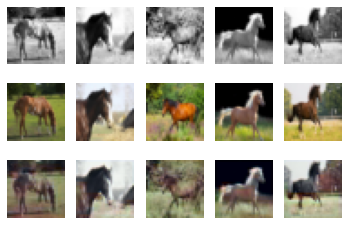

<Figure size 1080x1080 with 0 Axes>

In [152]:
# provide your code here
for i, (xs, ys) in enumerate(get_batch(testL, testab, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            img_grey = images
            img_real = labels
            batch_size = 7

            
            #discriminator training
            #d_optimizer.zero_grad()
            #real_prob = discriminator(img_real,img_grey)
            #real_labels=Variable(torch.ones(batch_size)).cuda()
            #real_loss = criterion(real_prob, real_labels)
            fake_images = cnn(img_grey)
            #fake_prob = discriminator(fake_images, img_grey)
            #fake_labels=Variable(torch.zeros(batch_size)).cuda()
            #fake_loss = criterion(fake_prob, fake_labels)
            #d_loss = real_loss + fake_loss
            #d_loss.backward()
            #d_optimizer.step()

            # generator training
            #g_optimizer.zero_grad()
            #fake_images = cnn(img_grey)
            #make_real = discriminator(fake_images, img_grey)
            #g_loss= criterion(make_real, real_labels)
            #g_loss.backward()
            #g_optimizer.step()

            img_real_final, gray_im=labtorgb(img_grey,img_real)
           

            img_fake_final, gray_im=labtorgb(img_grey,fake_images)
            gray_im=torch.tensor(gray_im)

            img_real=torch.tensor(img_real_final).permute(0,3,1,2)
            fake_images=torch.tensor(img_fake_final).permute(0,3,1,2)

            
            visual_bigger(gray_im, img_real, fake_images, args.gpu, 1)



### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [163]:
%%shell
jupyter nbconvert --to html /content/LAB_3_Generating_Data.ipynb

[NbConvertApp] Converting notebook /content/LAB_3_Generating_Data.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][151]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'Loading data...\n'
         'File path: data/cifar-10-batches-py.tar.gz\n'
         'Trans...'}
[NbConvertApp] Writing 159607539 bytes to /content/LAB_3_Generating_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus